# <center>Best movies of all times</center>
## <center>Comparison of data from IMDb and Rotten Tomatoes</center>
**<div align='right'>Made by Ihor Markevych</div>**

## Objective

1. Scrap top films from [IMDb](https://www.imdb.com/chart/top/) and [Rotten Tomatoes](https://www.rottentomatoes.com/top/bestofrt/) (RT) and extract
    1. Title
    1. Year
    1. Rating
    1. Number of reviews
1. Investigate possible connections between years, position in top, number of reviews and rating.
1. Compare user tendencies of those two services.
1. Visualize results.
1. Provide insights and recommendations in which films might users of each plotform like.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
imdbURL = 'https://www.imdb.com/chart/top/'
rtURL = 'https://www.rottentomatoes.com/top/bestofrt/'

## Data Mining

### IMDb

In [3]:
imdbPage = requests.get(imdbURL)
imdbSoup = BeautifulSoup(imdbPage.content)

In [4]:
imdbTop = pd.DataFrame([], columns=['Title', 'Year', 'Rating', 'Reviews'])


imdbTop.Title = [element.find('a').string 
                 for element in 
                 imdbSoup.findAll(attrs={"class": "titleColumn"})]

ratingsWithReviews = [re.findall('(\d\.\d) based on ([\d,]+) user ratings', element.get('title'))[0]
                      for element in 
                      imdbSoup.find(attrs={"class": "lister-list"}).findAll('strong')]

imdbTop.Rating = [float(rating[0]) for rating in ratingsWithReviews]
imdbTop.Reviews = [int(rating[1].replace(',', '')) for rating in ratingsWithReviews]

imdbTop.Year = [int(element.string.replace('(', '').replace(')', '')) 
                for element in 
                imdbSoup.findAll('span', attrs={"class": "secondaryInfo"})]
imdbTop = imdbTop.iloc[:100,:]

#### Review of scrapped information format from IMDb:

In [5]:
imdbTop

,Title,Year,Rating,Reviews
0,The Shawshank Redemption,1994,9.2,2189566
1,The Godfather,1972,9.1,1508602
2,The Godfather: Part II,1974,9.0,1056576
3,The Dark Knight,2008,9.0,2172281
4,12 Angry Men,1957,8.9,638454
...,...,...,...,...
95,The Hunt,2012,8.3,255972
96,Full Metal Jacket,1987,8.3,635882
97,North by Northwest,1959,8.3,281987
98,A Clockwork Orange,1971,8.3,716907


#### Top films year distribution:

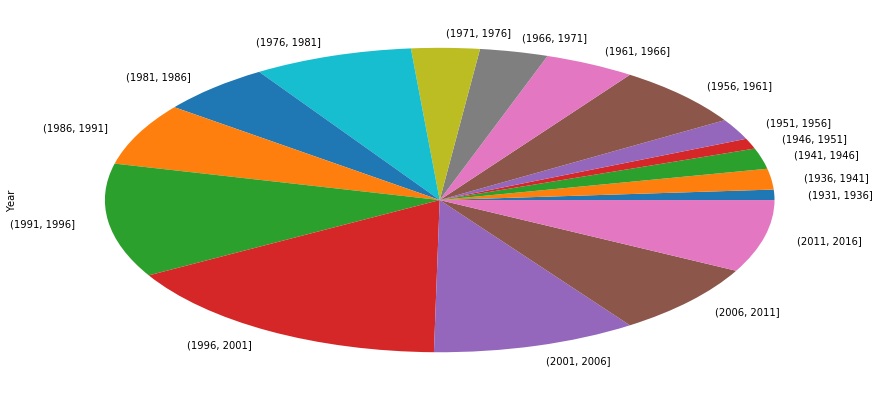

In [6]:
imdbTop.groupby(pd.cut(imdbTop.Year, 
                       [imdbTop.Year.min() + i * 5 
                        for i in 
                        range(int((imdbTop.Year.max() - imdbTop.Year.min()) / 5) + 1)])) \
                    .Year.count().plot.pie(figsize=(15, 7))
plt.show()

We can see that most films in IMDb top 100 are from 1990-2000 decade, while older films might have less share.

#### Total number of comments for top films by year:

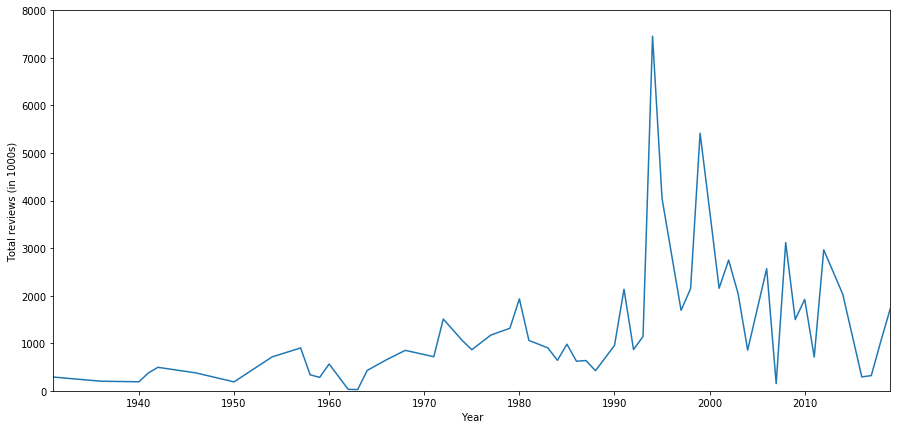

In [7]:
imdbTop.groupby(by='Year').Reviews.sum().plot.line(figsize=(15, 7))
plt.xlabel('Year')
plt.ylim(bottom=0)
locs, labels = plt.yticks()
plt.yticks(locs, [int(l // 1000) for l in locs])
plt.ylabel('Total reviews (in 1000s)')
plt.show()

It can be infered from this plot that most commented top films are from recent years, with most comments on years 1995 and 2000.

#### Rating distribution:

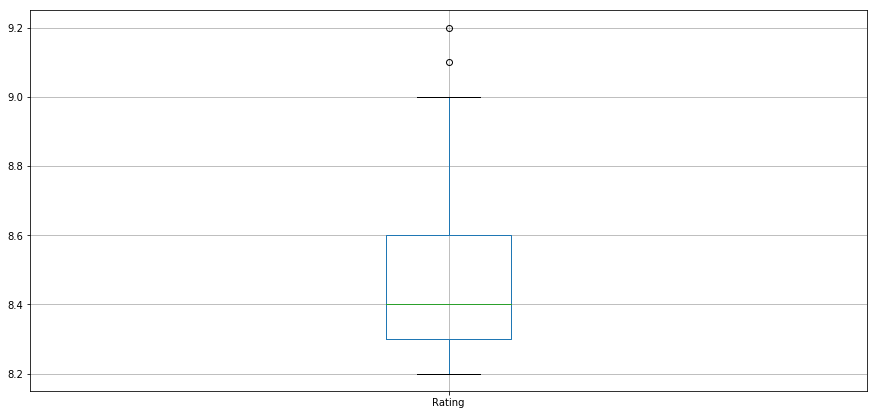

In [8]:
imdbTop.boxplot('Rating', figsize=(15, 7))
plt.show()

Average rating is 8.4, with ratings range between 8.6 and 8.3. Almost all ratings are between 8.2 and 9.0.

#### Comparing ratings by film position:

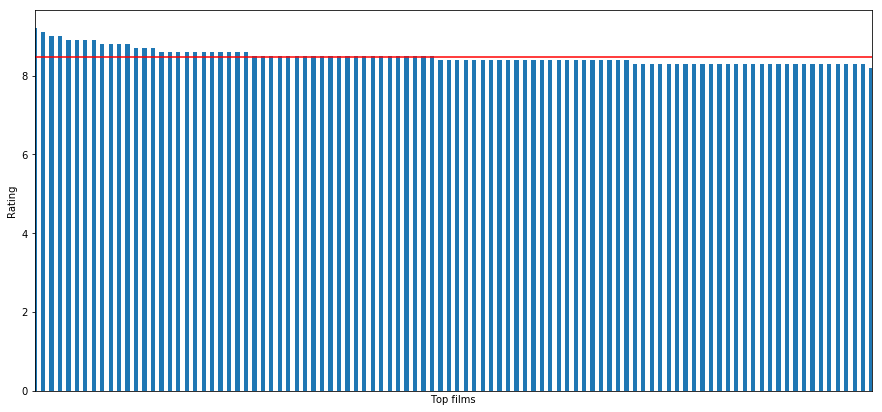

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

imdbMean = imdbTop[['Rating']]
imdbMean.Rating.values[:] = imdbTop[['Rating']].mean()

imdbTop.Rating.plot.bar(ax=ax)
imdbMean.Rating.plot.line(ax=ax, c='red')

plt.xlabel('Top films')
plt.ylabel('Rating')
plt.xticks([])
plt.show()

It can be seen that all reviews are very close to mean, which makes even slight differences matter. It can be also seen that few first films has significantly higher ratings, while middle-top films have very close rating.

### Rotten Tomatoes

In [10]:
rtTop = pd.DataFrame([], columns=['Title', 'Year', 'Rating', 'Reviews'])

rtPage = requests.get(rtURL)
rtSoup = BeautifulSoup(rtPage.content)

In [11]:
titlesWithYear = [re.findall('(.+) \((\d{4})\)', element.string.replace('\n', '').replace('  ', ''))[0] 
                   for element in 
                   rtSoup.find(attrs={"class": "panel-body content_body allow-overflow"})
                   .find('table')
                   .findAll(attrs={"class": "unstyled articleLink"})]

rtTop.Title = [s[0] for s in titlesWithYear]
rtTop.Year = [int(s[1]) for s in titlesWithYear]

rtTop.Rating = [int(element.string.replace('\xa0', '').replace('%', '')) 
                for element in 
                rtSoup.find(attrs={"class": "panel-body content_body allow-overflow"})
                .find('table')
                .findAll(attrs={"class": "tMeterScore"})]

rtTop.Reviews = [int(element.string)
                 for element in 
                 rtSoup.find(attrs={"class": "panel-body content_body allow-overflow"})
                 .find('table')
                 .findAll(attrs={"class": "right hidden-xs"})[1:]]

#### Review of scrapped information format from Rotten Tomatoes:

In [12]:
rtTop

,Title,Year,Rating,Reviews
0,Black Panther,2018,97,493
1,Avengers: Endgame,2019,94,504
2,Us,2019,93,513
3,Toy Story 4,2019,97,427
4,Mission: Impossible - Fallout,2018,97,415
...,...,...,...,...
95,Pinocchio,1940,100,51
96,The Lady Vanishes,1938,98,43
97,The 400 Blows (Les Quatre cents coups),1959,100,60
98,Toy Story 3,2010,98,305


#### Top films year distribution:

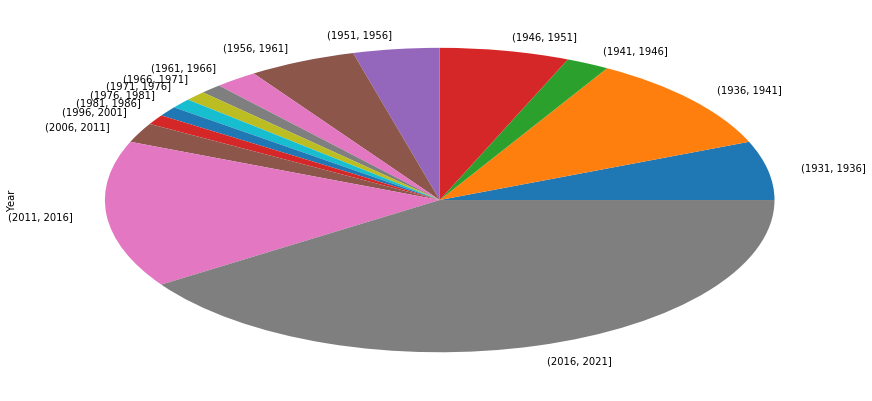

In [13]:
rtTop.groupby(pd.cut(rtTop.Year, 
                       [imdbTop.Year.min() + i * 5 
                        for i in 
                        range(int((rtTop.Year.max() - rtTop.Year.min()) / 5) + 1)])) \
                    .Year.count().plot.pie(figsize=(15, 7))
plt.show()

We can conclude that Rotten Tomatoes has a tendency of having most recent films in its top.

#### Total number of comments for top films by year:

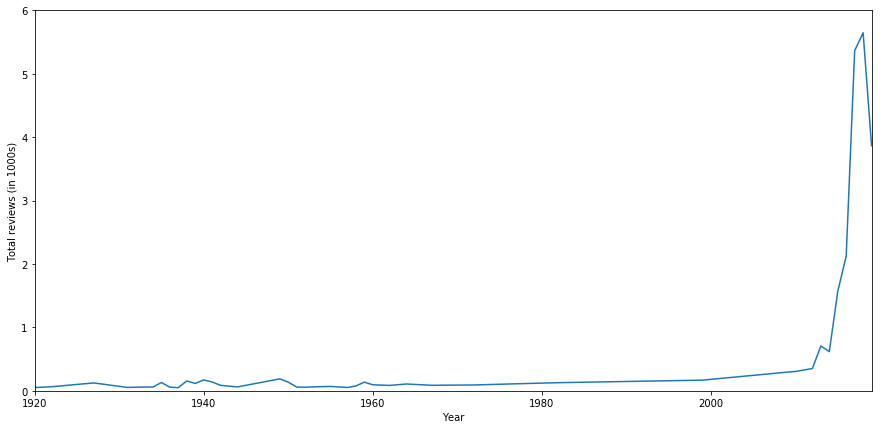

In [14]:
rtTop.groupby(by='Year').Reviews.sum().plot.line(figsize=(15, 7))
plt.xlabel('Year')
plt.ylim(bottom=0)
locs, labels = plt.yticks()
plt.yticks(locs, [int(l // 1000) for l in locs])
plt.ylabel('Total reviews (in 1000s)')
plt.show()

With Rotten Tomatoes there is a clear picture of most recent films being most reviewed. This is corroborated by previous pie plot.

#### Rating distribution:

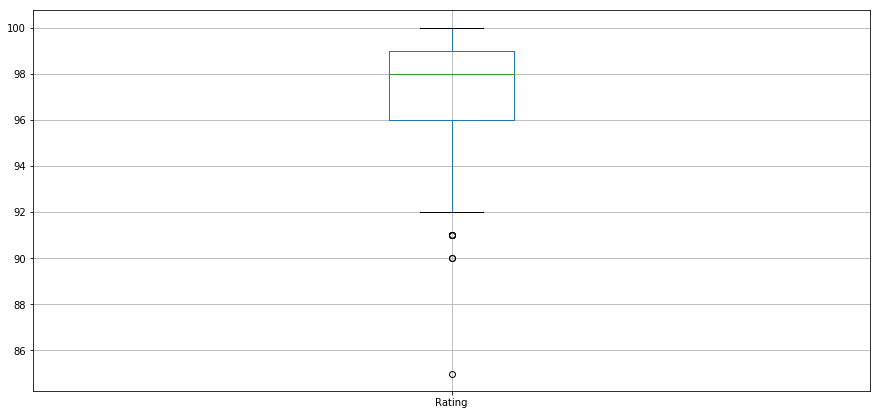

In [15]:
rtTop.boxplot('Rating', figsize=(15, 7))
plt.show()

Average rating is 98, with ratings range between 99 and 96. Almost all ratings are between 92 and 100. Looks like RT users tend to give higher ratings to the films.

#### Comparing ratings by film position:

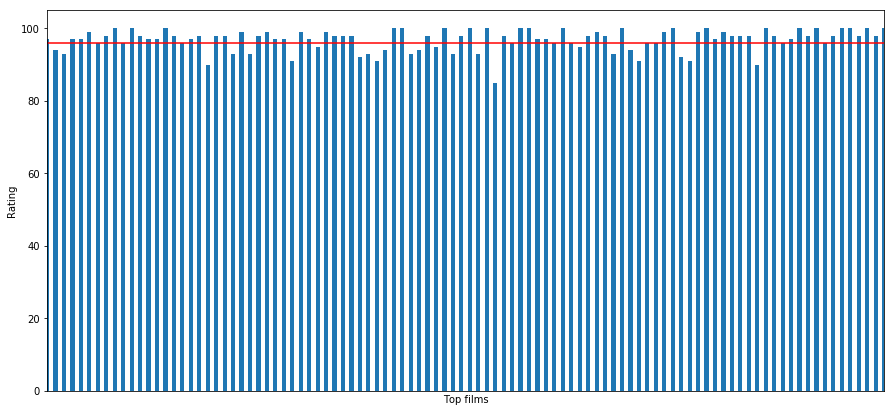

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

rtMean = rtTop[['Rating']]
rtMean.Rating.values[:] = rtTop[['Rating']].mean()

rtTop.Rating.plot.bar(ax=ax)
rtMean.Rating.plot.line(ax=ax, c='red')

plt.xlabel('Top films')
plt.ylabel('Rating')
plt.xticks([])
plt.show()

Note: for ranking Rotten Tomatoes use their own rating that is being calculated as weighted rating of users.  
  
This visualization represents that users of Rotten Tomatoes tend to give much more ranged ratings, which can be explained by significantly smaller number of reviews in comparison to IMDb.

## Findings

* IMDb has significantly more reviews for films, which makes ratings more balanced and accurate.  
* For IMDb average rating is 8.4, with ratings range between 8.6 and 8.3. Almost all ratings are between 8.2 and 9.0.
* The most commented top films are from recent years, with most comments on years 1995 and 2000. 
* Most films in IMDb top 100 are from 1990-2000 decade, while older films might have less share.
* All reviews are very close to mean, which makes even slight differences matter. It can be also seen that few first films has significantly higher ratings, while middle-top films have very close rating.

  
* RT users like more recent films.  
* RT users tend to give higher scores.
* RT has a tendency of having most recent films in its top.
* On RT most recent films being most reviewed.
* In RT top average rating is 98, with ratings range between 99 and 96. Almost all ratings are between 92 and 100. 
* Looks like RT users tend to give higher ratings to the films.
* Users of RT tend to give much more ranged ratings.

## Recommendations

**Rotten Tomatoes**
1. We can assume that getting in top on Rotten Tomatoes will be significantly easier in comparison to IMDb.
1. For Rotten Tomatoes recent films have tendency to be more viewed and more reviewed, so, it will be easier to get in top for them.
1. If film selection for some festival or cinematic event will be aimed on Rotten Tomatoes users, organizators should take closer look on more recent films.
  
**IMDb**
1. Getting into IMDb top is extremely hard.
1. IMDb users tend to like older films and since they have a lot of reviews, new films will need significant amount of time to get high enough rating to get even close to top.
1. If film selection will be pointed at IMDb top, more classical films should be selected.